# Module 10 - Regression Algorithms - Decomposing Linear Models Into Their Coefficients and Model Composition

In the last few notebooks, I covered the baseline Linear Regression (OLS), Ridge, and LASSO. Linear Regression finds the line of best fit through the least squares loss function, however, is subject to overfitting the training data sets.

To smooth out the models, we can use Ridge which tries to "even out" all the coefficients, or use LASSO which tries to reduce model complexity.

In the Log-Log models, since all continuous inputs have been standardized, we can compare relative importance out of them, but, also see how they combine into the model.

We can also plot the indiviudal coefficient lines and see how they build the model together.

If we define a linear space x of intervals, we can calculate what each coefficient would be at that value of x. Then we can graph them to see how the composition works.

For model interpretation this is pretty useless, however, it's interesting to see how the models differ in preventing overfitting. *(Placing $x=1$ on all log coefficients probably doesn't correlate into an actual car.)*

I'm going to start by importing everything from the notebook *mod10-regression-ridge-lasso-log-log-models.ipynb*.

## Part A: Setting Up Log-Log Models for Linear Regression, Ridge, and LASSO

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn import set_config
set_config(display='diagram')

In [2]:
loc = "https://raw.githubusercontent.com/mhall-simon/python/main/data/car-mpg/auto-mpg.data"

df = pd.read_csv(loc, sep="\s+", header=None, na_values="?")

cols = {0:"mpg", 1:"cylinders", 2:"displacement", 3:"horsepower", 4:"weight", 5:"accel", 6:"year", 7:"origin", 8:"model"}
df = df.rename(columns=cols)

df = df.replace(np.nan, df.horsepower.mean())

df = df.drop("model", axis=1)

X = df.iloc[:,1:]
y = df.iloc[:,0]

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=107)

In [4]:
categorical_columns = ['cylinders','origin','year']
numerical_columns = ['displacement','horsepower','weight','accel']

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

numerical_transformer = Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)),
                                        ('scaler', StandardScaler())])

In [5]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [6]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)])

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

linear = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression(),
        func = np.log,
        inverse_func = np.exp
    )
)

linear.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

In [8]:
from sklearn.linear_model import Ridge

ridge = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=0.2442053094548655),
        func = np.log,
        inverse_func = np.exp
    )
)

ridge.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge(alpha=0.2442053094548655)))])

In [9]:
from sklearn.linear_model import Lasso

lasso = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=0.0001325711365590111, max_iter=100000),
        func = np.log,
        inverse_func = np.exp
    )
)

lasso.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False,
                                                                                      interaction_only=True)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['displacement', 'horsepower',
                                                   'weight', 'accel']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cylinders', 'origin',
                                                   'year'])])),
                ('transformedtargetregressor',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Lasso(alpha=0.0001325711365590111,
                                                            max_iter=100000)))])

## Part B: Extracting Continuous Coefficients Out of Each Model

In [10]:
numerical_names = linear.named_steps['columntransformer'].named_transformers_['num'].steps[0][1].get_feature_names(input_features=numerical_columns)

categorical_names = linear.named_steps['columntransformer'].named_transformers_['cat'].get_feature_names(input_features=categorical_columns)

feature_names = np.concatenate([numerical_names, categorical_names])
feature_names

array(['displacement', 'horsepower', 'weight', 'accel',
       'displacement horsepower', 'displacement weight',
       'displacement accel', 'horsepower weight', 'horsepower accel',
       'weight accel', 'displacement horsepower weight',
       'displacement horsepower accel', 'displacement weight accel',
       'horsepower weight accel', 'cylinders_3', 'cylinders_4',
       'cylinders_5', 'cylinders_6', 'cylinders_8', 'origin_1',
       'origin_2', 'origin_3', 'year_70', 'year_71', 'year_72', 'year_73',
       'year_74', 'year_75', 'year_76', 'year_77', 'year_78', 'year_79',
       'year_80', 'year_81', 'year_82'], dtype=object)

In [11]:
coefs = pd.DataFrame(
    linear.named_steps['transformedtargetregressor'].regressor_.coef_,
    columns=['linear'], index=feature_names
)

coefs.head()

,linear
displacement,0.524207
horsepower,-0.432599
weight,-0.397328
accel,-0.056845
displacement horsepower,-0.562751


Now, let's add columns for Ridge and LASSO:

In [12]:
coefs['ridge'] = ridge.named_steps['transformedtargetregressor'].regressor_.coef_
coefs['lasso'] = lasso.named_steps['transformedtargetregressor'].regressor_.coef_

In [13]:
coefs.iloc[0:14,:]

,linear,ridge,lasso
displacement,0.524207,-0.236925,-0.270470
horsepower,-0.432599,0.069555,0.042707
weight,-0.397328,-0.121549,-0.116217
accel,-0.056845,0.038815,0.024924
displacement horsepower,-0.562751,-0.066949,0.000000
displacement weight,-0.887620,0.010615,-0.000000
displacement accel,-0.755794,0.012768,0.000000
horsepower weight,1.386067,0.021745,0.000000
horsepower accel,0.337325,-0.028563,0.000000
weight accel,0.248500,-0.064649,-0.059416


In [14]:
lin = np.linspace(-5,5,100)

Let's plot our coefficients for the linear regression:

The gray lines are the individual components, and the red line is the entire weighted regression line.

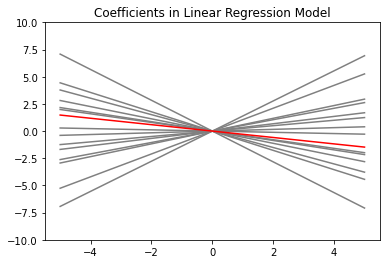

In [15]:
# Plot for Linear Regression:
summed = coefs.iloc[0:14,0].sum()

for i in range(14):
    plt.plot(lin, lin*coefs.iloc[i,0], color='grey')

plt.plot(lin, lin*summed, color='red')
plt.ylim([-10,10])
plt.title("Coefficients in Linear Regression Model")
plt.show();

Key things to take away from this graph is that there's a lot of strongly positive and negative coefficients, that are offsetting each other to get to the red line.

A big concern for this is that the patterns found in the training set may have been overfit compared to the true population estimates, making the model less reliable for predictions.

Ridge helps us out by providing smoothing to the model:

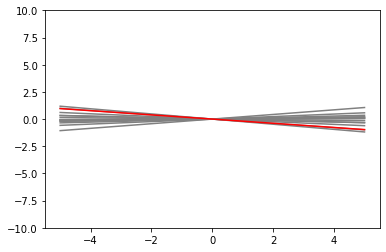

In [16]:
# Plot for Ridge
summed = coefs.iloc[0:14,1].sum()

for i in range(14):
    plt.plot(lin, lin*coefs.iloc[i,1], color='grey')

plt.plot(lin, lin*summed, color='red')
plt.ylim([-10,10])
plt.show();

The red predictive line is nearly the same as the one above, however, there's a lot less variation with the coefficients in the model.

This smoothing is why Ridge models are preferred, and can prevent overfitting trends found in the training data.

Let's compare it to LASSO:

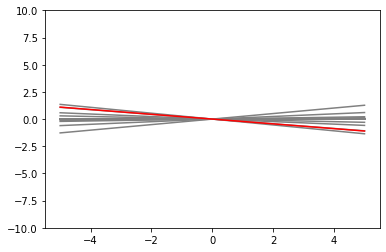

In [17]:
# Plot for LASSO
summed = coefs.iloc[0:14,2].sum()

for i in range(14):
    plt.plot(lin, lin*coefs.iloc[i,2], color='grey')

plt.plot(lin, lin*summed, color='red')
plt.ylim([-10,10])
plt.show();

If we plot the three lines, we see that they're very similar, however, the Ridge and LASSO models significantly reduced complexity and are less likely to "overfit" testing data.

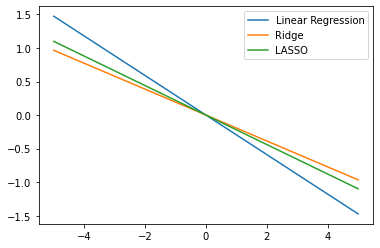

In [18]:
summed = coefs.iloc[0:14,0].sum()
plt.plot(lin, lin*summed, label="Linear Regression")

summed = coefs.iloc[0:14,1].sum()
plt.plot(lin, lin*summed, label="Ridge")

summed = coefs.iloc[0:14,2].sum()
plt.plot(lin, lin*summed, label="LASSO")

plt.legend()
plt.show();

Trying to decide between a Ridge and LASSO?

It's up to you, however, LASSO models are usually easier to explain over Ridge!

Don't want to decide? Use Stacking to weight the models we made together into one! (Check out last NB in the regression series. However, we usually use a Ridge to weight the models!)